In [1]:
import pandas as pd
import numpy as np
import nltk
import json
import io
import dateutil
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools
import warnings

from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud


warnings.filterwarnings("ignore")
sns.set()
plt.rcParams["font.serif"] = "cmr10"

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [2]:
stop_words = set(
    stopwords.words('english') + list(punctuation) + ['AT_USER', 'URL'])

In [3]:
def get_tweets_from_json_file(mode):
    """
    :param mode: can be "kcca", "moh", "influencers", "moh_engagement" e.t.c depending on the data being analyzed
    """
    filename = "{}_analysis_tweets.json".format(mode)
    with io.open(filename, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        f.close()
    return json_data['tweets']

In [4]:
moh_engagement_tweets = get_tweets_from_json_file("moh_engagement")

In [6]:
print("Number of tweets: {}".format(len(moh_engagement_tweets)))

Number of tweets: 1006


In [21]:
def get_tweet_words(tweet):
    """Clean up tweet"""
    
    tweet = tweet.lower()  # convert text to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL',
                   tweet)  # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet)  # remove usernames
    tweet = re.sub(r'#([\w]+)', '', tweet)  # remove the # in #hashtag
    tweet = word_tokenize(
        tweet)  # remove repeated characters (helloooooooo into hello)
    return [word for word in tweet if word not in stop_words and len(word) > 3]


def is_retweet(tweet):
    if "referenced_tweets" in tweet:
        ref_tweets = tweet["referenced_tweets"]
        for ref_t in ref_tweets:
            if ref_t['type'] == 'retweeted':
                return True
    return False

def filter_tweets(tweets):
    return [tweet for tweet in tweets if not (is_retweet(tweet) or tweet['username'].isnumeric())]


def process_tweet(tweet):
    """Process tweets from raw files"""
    username = tweet['username']
    user_id = tweet['user_id']
    tweet_id = tweet['id']
    created_time = dateutil.parser.parse(
        tweet['created_at']).replace(tzinfo=None)
    text = tweet['text']
    words = get_tweet_words(text)
    retweet_count = tweet['public_metrics']['retweet_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    like_count = tweet['public_metrics']['like_count']
    engagement = retweet_count + reply_count + quote_count + like_count
#     followers_count = tweet['user']['followers_count']
    return {
        'username': username,
        'user_id': user_id,
        'tweet_id': tweet_id,
        'created_time': created_time,
        'text': text,
        'words': words,
        'retweet_count': retweet_count,
        'reply_count': reply_count,
        'quote_count': quote_count,
        'like_count': like_count,
        'engagement': engagement
    }


def create_pd_frame(tweets):
    filtered_tweets = filter_tweets(tweets)
    df = pd.DataFrame([process_tweet(tweet) for tweet in filtered_tweets])
    df.set_index('created_time', inplace=True)
    return df

In [24]:
df = create_pd_frame(moh_engagement_tweets)

In [25]:
df.shape

(455, 10)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2020-10-04 14:39:27 to 2020-10-11 12:50:14
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       455 non-null    object
 1   user_id        455 non-null    object
 2   tweet_id       455 non-null    object
 3   text           455 non-null    object
 4   words          455 non-null    object
 5   retweet_count  455 non-null    int64 
 6   reply_count    455 non-null    int64 
 7   quote_count    455 non-null    int64 
 8   like_count     455 non-null    int64 
 9   engagement     455 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 30.2+ KB


In [27]:
df.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement
created_time,,,,,,,,,,
2020-10-04 14:39:27,Walter Mwesigye @MwesigyeWalter,479217587,1312764274448662528,@Arsenal 💪🏾💪🏾💪🏾👏🏽😁,[💪🏾💪🏾💪🏾👏🏽😁],0,0,0,1,1
2020-10-04 14:57:45,Daraus Bahikire @DarausBahikire,3246146740,1312768879681302528,UPDF now serves the broader continental intere...,"[updf, serves, broader, continental, interests...",0,0,1,3,4
2020-10-04 15:45:12,Walter Mwesigye @MwesigyeWalter,479217587,1312780819774267393,Man U minutes into the game nowuliira emilanga...,"[minutes, game, nowuliira, emilanga, ....., 🤣🤣...",4,4,0,18,26
2020-10-04 16:10:15,Walter Mwesigye @MwesigyeWalter,479217587,1312787125667012612,Man U fans are now insulting every living and ...,"[fans, insulting, every, living, non-living, t...",2,5,1,35,43
2020-10-04 16:24:13,Walter Mwesigye @MwesigyeWalter,479217587,1312790639600373760,@NakiwalaSandra @KomugishaOlivia 🤣🤣,[],0,0,0,0,0


### Comparing the different Engagers

In [28]:
usernames = list(df['username'])
usernames_freq = nltk.FreqDist(usernames)
usernames_df = pd.DataFrame({
    'Username': list(usernames_freq.keys()),
    'Count': list(usernames_freq.values())
})

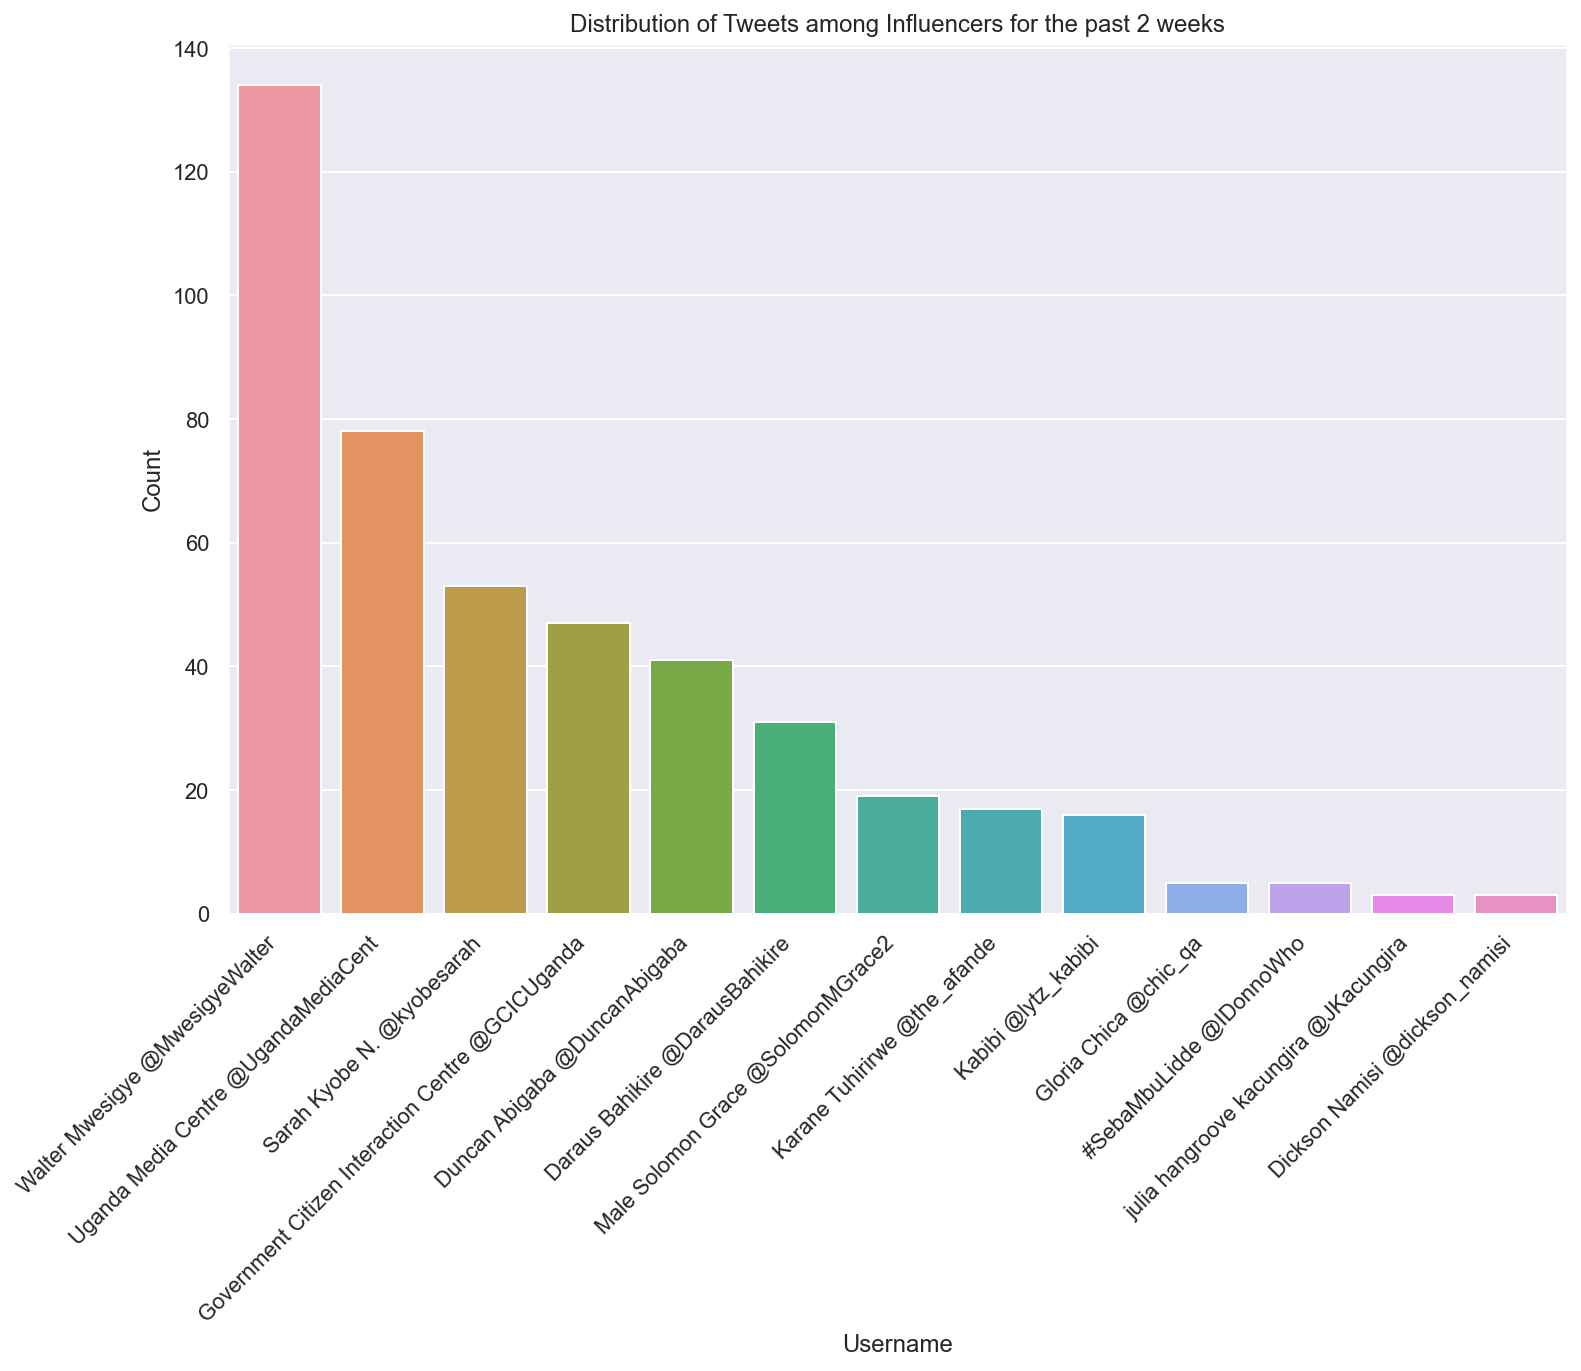

In [29]:
popular_users = usernames_df.nlargest(columns='Count', n=13)
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y='Count', data=popular_users, ax=axes)
ax.set(ylabel="Count")
ax.set_title("Distribution of Tweets among Influencers for the past 2 weeks")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

#### Engagement received for each user

In [30]:
columns_to_show = ["username", "retweet_count", "reply_count", "quote_count", "like_count", "engagement"]

eng_df = df.groupby(['username'])[columns_to_show]

In [31]:
aggregate = eng_df.agg([np.mean])
average_engagement_df = pd.DataFrame({
    "Username": list(eng_df.groups.keys()),
    "Average Engagement": list(aggregate[('engagement', 'mean')])
})

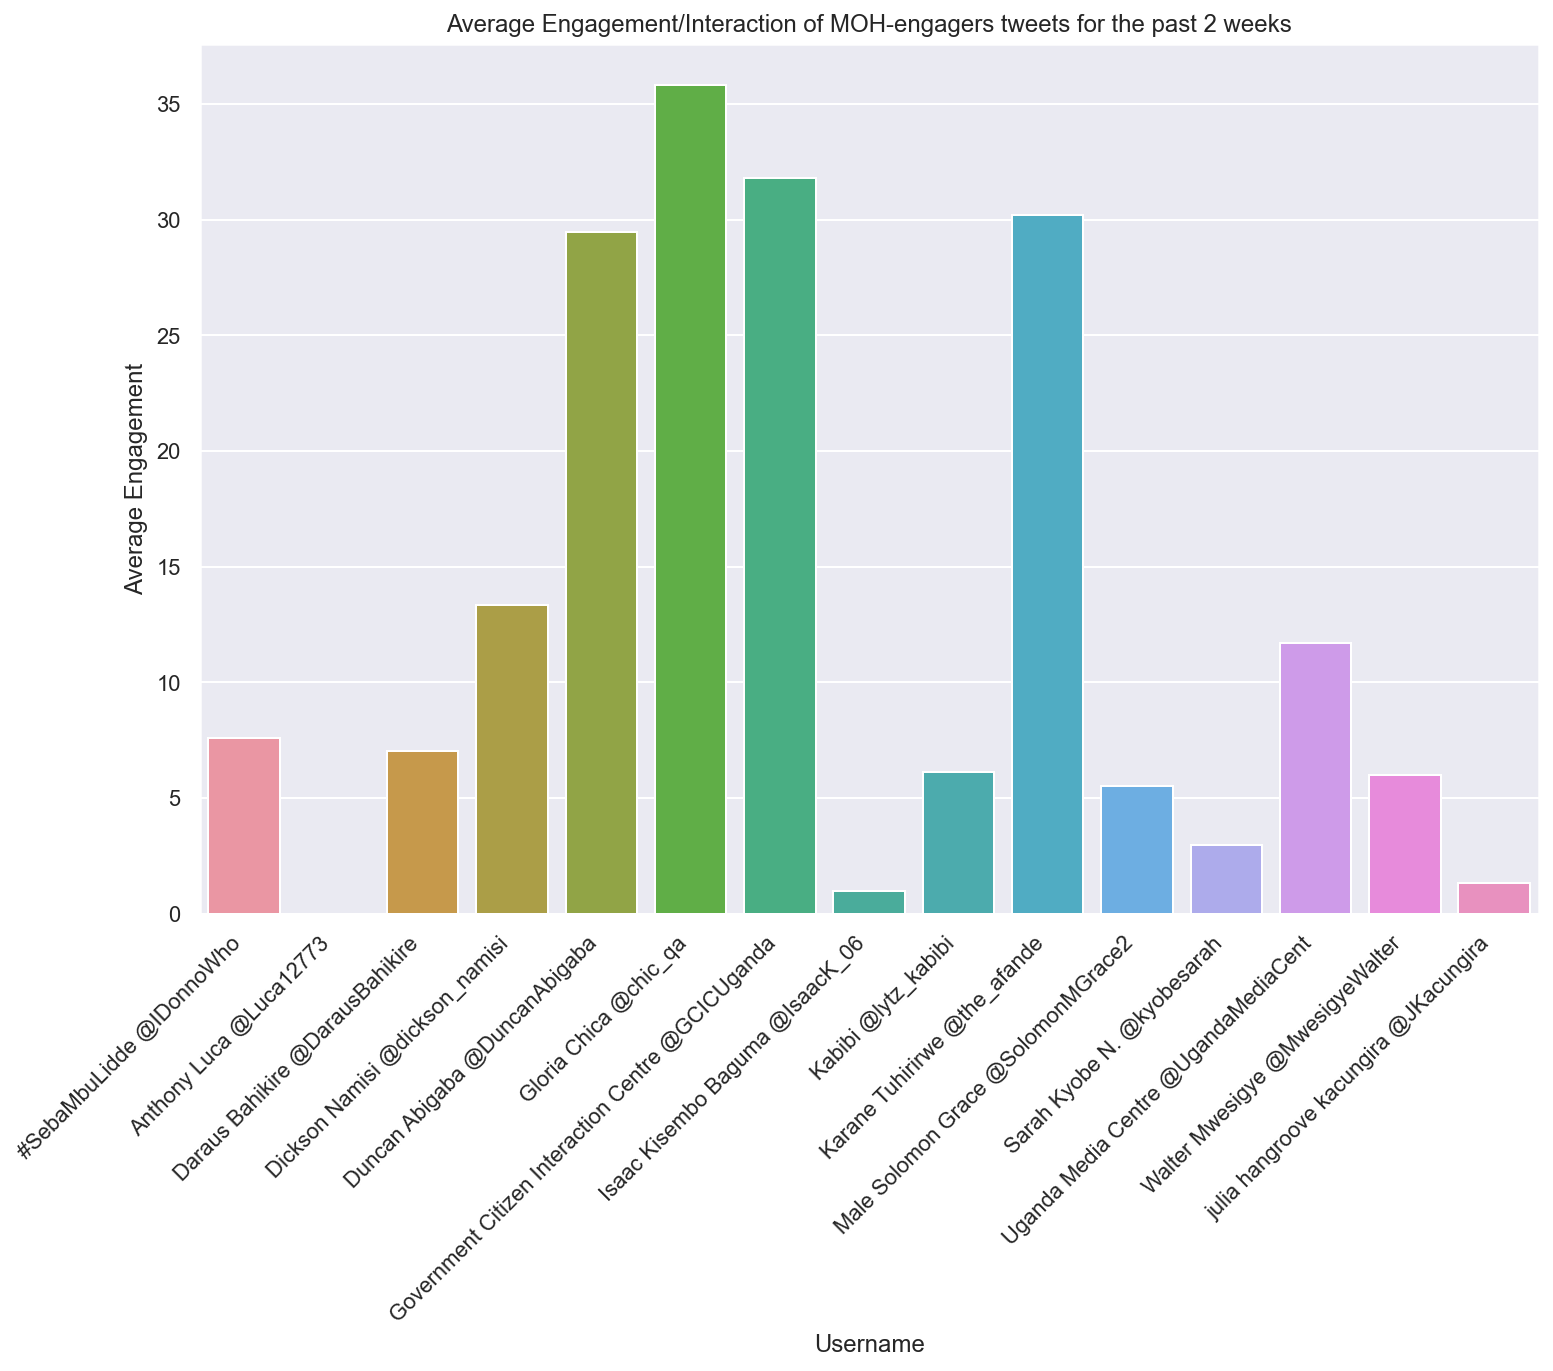

In [34]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y="Average Engagement", data=average_engagement_df, ax=axes)
ax.set(ylabel='Average Engagement')
ax.set_title("Average Engagement/Interaction of MOH-engagers tweets for the past 2 weeks")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

## Analysis of COVID Tweets

In [35]:
covid_words = ["covid", "covid19", "corona", "coronavirus", "mask", "masks", "lockdown", 
               "staysafe", "virus", "cov", "stayhome", "staysafeug", "socialdistance", "washyourhands", "wearamask"]
def is_covid_related_tweet(tweet_words):
    for word in covid_words:
        if word in tweet_words:
            return True
    return False

In [36]:
covid_tweets = df[df['words'].apply(lambda t_words: is_covid_related_tweet(t_words))]

In [37]:
covid_tweets.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement
created_time,,,,,,,,,,
2020-10-06 07:33:16,Uganda Media Centre @UgandaMediaCent,398537661,1313381796260741122,.@MorikuJoyce: The Integrated Child Health Act...,"[.AT_USER, integrated, child, health, activiti...",0,1,0,1,2
2020-10-06 08:54:33,Uganda Media Centre @UgandaMediaCent,398537661,1313402252984561665,.@GenWamala: Anyone that presents fake #Covid_...,"[.AT_USER, anyone, presents, fake, results, ai...",1,0,0,3,4
2020-10-06 10:38:39,#SebaMbuLidde @IDonnoWho,253662548,1313428451869765633,The only time of the day when we get to put th...,"[time, mask, away, sanitize, time, enjoy, lunch]",0,0,0,0,0
2020-10-06 11:43:48,Government Citizen Interaction Centre @GCICUganda,765577387811667968,1313444844652683264,#COVID_19 ADVISORY\n\nWear a mask that covers ...,"[advisory, wear, mask, covers, nose, mouth, he...",12,0,0,23,35
2020-10-07 11:00:15,Government Citizen Interaction Centre @GCICUganda,765577387811667968,1313796275695910913,#COVID_19 ADVISORY\n\n🚍✈️Travel increases your...,"[advisory, 🚍✈️travel, increases, chances, gett...",13,1,0,15,29


In [38]:
covid_tweets.shape

(8, 10)

### Frequency of covid tweets

In [39]:
daily_covid = covid_tweets['tweet_id'].groupby([covid_tweets.index.date]).count()

In [52]:
daily_covid.axes

[Index([2020-10-06, 2020-10-07, 2020-10-08, 2020-10-09], dtype='object')]

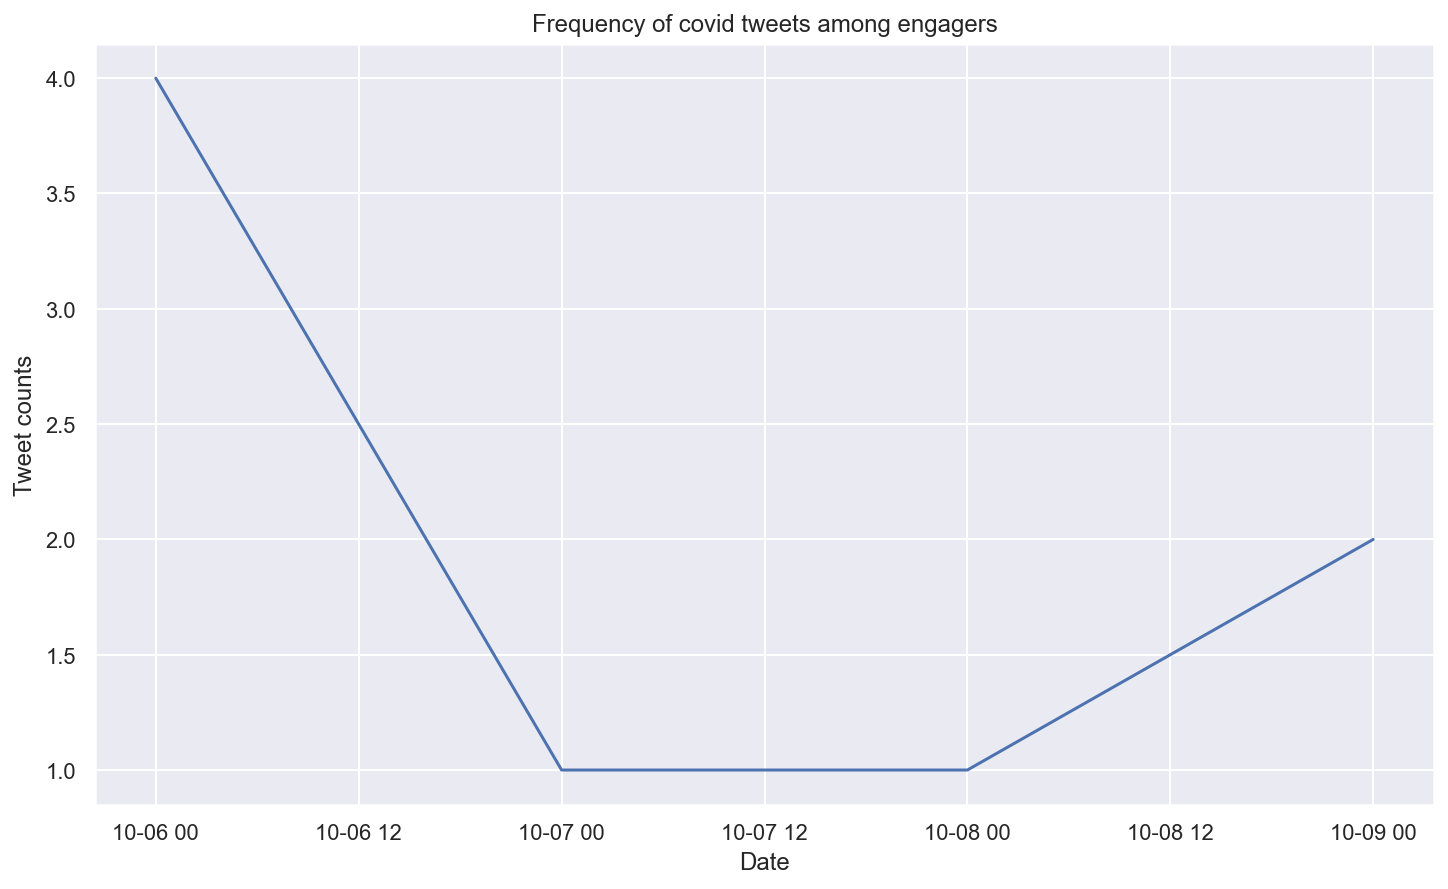

In [55]:
ax = daily_covid.plot(figsize=(12, 7))

ax.set(title="Frequency of covid tweets among engagers")
ax.set(ylabel="Tweet counts")
ax.set(xlabel="Date")

plt.show()